# Drought risk

Assessment of model percentage multiannual drought (as a proxy for drought risk) bias over the 2000-2019 period.

(Bias corrected data for the period 2000-2019 was produced by training on data from the 1980-1999 period.)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs

sys.path.append('/g/data/xv83/users/at2708/bias_adjustment/evaluation/npcp/results')
import utils

In [2]:
def calc_drought(da, var):
    """
    calculate multiannual drought - the minimum of precipitation as a %-deviation of the climatological mean
    """
    annual_mean= da.groupby('time.year').sum(dim='time')
    annual_mean_min = annual_mean.min(dim='year')
    annual_mean_mean = annual_mean.mean(dim='year')
    drought_risk = ((annual_mean_min - annual_mean_mean) / abs(annual_mean_mean)) * 100

    moving_avg_2yr = da.groupby('time.year').sum(dim='time').rolling(year=2, min_periods=1, center=True).mean()#.dropna("year")
    min_moving_avg_2yr = moving_avg_2yr.min(dim='year')
    mean_moving_avg_2yr = moving_avg_2yr.mean(dim='year')
    drought_risk_2yr = ((min_moving_avg_2yr - mean_moving_avg_2yr) / abs(mean_moving_avg_2yr)) * 100
    
    moving_avg_5yr = da.groupby('time.year').sum(dim='time').rolling(year=5, min_periods=1, center=True).mean()#.dropna("year")
    min_moving_avg_5yr = moving_avg_5yr.min(dim='year')
    mean_moving_avg_5yr = moving_avg_5yr.mean(dim='year')
    drought_risk_5yr = ((min_moving_avg_5yr - mean_moving_avg_5yr) / abs(mean_moving_avg_5yr)) * 100  

    return drought_risk, drought_risk_2yr, drought_risk_5yr



In [3]:
def get_data(var, rcm):
    """Get data needed for the evaluation"""

    assert rcm in ['BOM-BARPA-R', 'UQ-DES-CCAM-2105']
    
    da_obs = utils.get_npcp_data(
        var,
        'observations',
        'AGCD',
        'raw',
        'task-reference',
        '2000-01-01',
        '2019-12-31',
        'AU'
    )   
    da_gcm = utils.get_npcp_data(
        var,
        'CSIRO-ACCESS-ESM1-5',
        'GCM',
        'raw',
        'task-reference',
        '2000-01-01',
        '2019-12-31',
        'AU'
    )
    da_rcm_raw = utils.get_npcp_data(
        var,
        'CSIRO-ACCESS-ESM1-5',
        rcm,
        'raw',
        'task-reference',
        '2000-01-01',
        '2019-12-31',
        'AU'
    )
    da_rcm_ecdfm = utils.get_npcp_data(
        var,
        'CSIRO-ACCESS-ESM1-5',
        rcm,
        'ecdfm',
        'task-historical',
        '2000-01-01',
        '2019-12-31',
        'AU'
    )
    # TODO: Add additional bias correction methods as data becomes available 

    return da_obs, da_gcm, da_rcm_raw, da_rcm_ecdfm

In [4]:
def plot_mean_bias(ax, da_obs, da_model, var, cmap, levels, model_name, mode):
    """Plot the mean bias for a particular model"""
    
    drought_risk_obs, drought_risk_2yr_obs, drought_risk_5yr_obs = calc_drought(da_obs, var)
    drought_risk_model, drought_risk_2yr_model, drought_risk_5yr_model = calc_drought(da_model, var)

    if mode == 'drought risk':
        bias = drought_risk_model - drought_risk_obs
    elif mode == 'drought risk 2-yr moving window':
        bias = drought_risk_2yr_model - drought_risk_2yr_obs
    elif mode == 'drought risk 5-yr moving window':
        bias = drought_risk_5yr_model - drought_risk_5yr_obs
    else:
        print('Invalid mode')
        return
    
    units = '%' 
    
    im = bias.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend='both', 
        add_colorbar=False
    ) #cbar_kwargs={'label': units},
    ax.set_title(model_name)
    ax.coastlines()
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.04)
    cbar.ax.tick_params(labelsize=14)  
    cbar.set_label(units, fontsize=14) 


In [5]:
def plot_comparison(var, rcm, cmap, levels):
    """Plot the complete comparison"""

    da_obs, da_gcm, da_rcm_raw, da_rcm_ecdfm = get_data(var, rcm)

    modes= ['drought risk', 'drought risk 2-yr moving window', 'drought risk 5-yr moving window']
        
    rows, cols = len(modes), 3  
    
    fig, axs = plt.subplots(rows, cols, figsize=[24, 6*rows], subplot_kw={'projection': ccrs.PlateCarree()})
    
    for row, mode in enumerate(modes):

        ax1 = axs[row, 0]
        ax2 = axs[row, 1]
        ax3 = axs[row, 2]

        # Plot GCM bias
        plot_mean_bias(ax1, da_obs, da_gcm, 'pr', cmap, levels, 'CSIRO-ACCESS-ESM1-5', mode)
        ax1.set_title(f'CSIRO-ACCESS-ESM1-5 ({mode})', fontsize=16)

        # Plot RCM raw bias
        plot_mean_bias(ax2, da_obs, da_rcm_raw, 'pr', cmap, levels, f'{rcm} (raw)', mode)
        ax2.set_title(f'{rcm} (raw) ({mode})', fontsize=16)

        # Plot RCM bias corrected bias
        plot_mean_bias(ax3, da_obs, da_rcm_ecdfm, 'pr', cmap, levels, f'{rcm} (ecdfm)', mode)
        ax3.set_title(f'{rcm} (ecdfm) ({mode})', fontsize=16)
    
    long_name = da_rcm_raw.attrs['long_name']
    plt.suptitle(f' Drought risk bias (model minus obs) for different modes in the 2000-2019 {long_name}', fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()


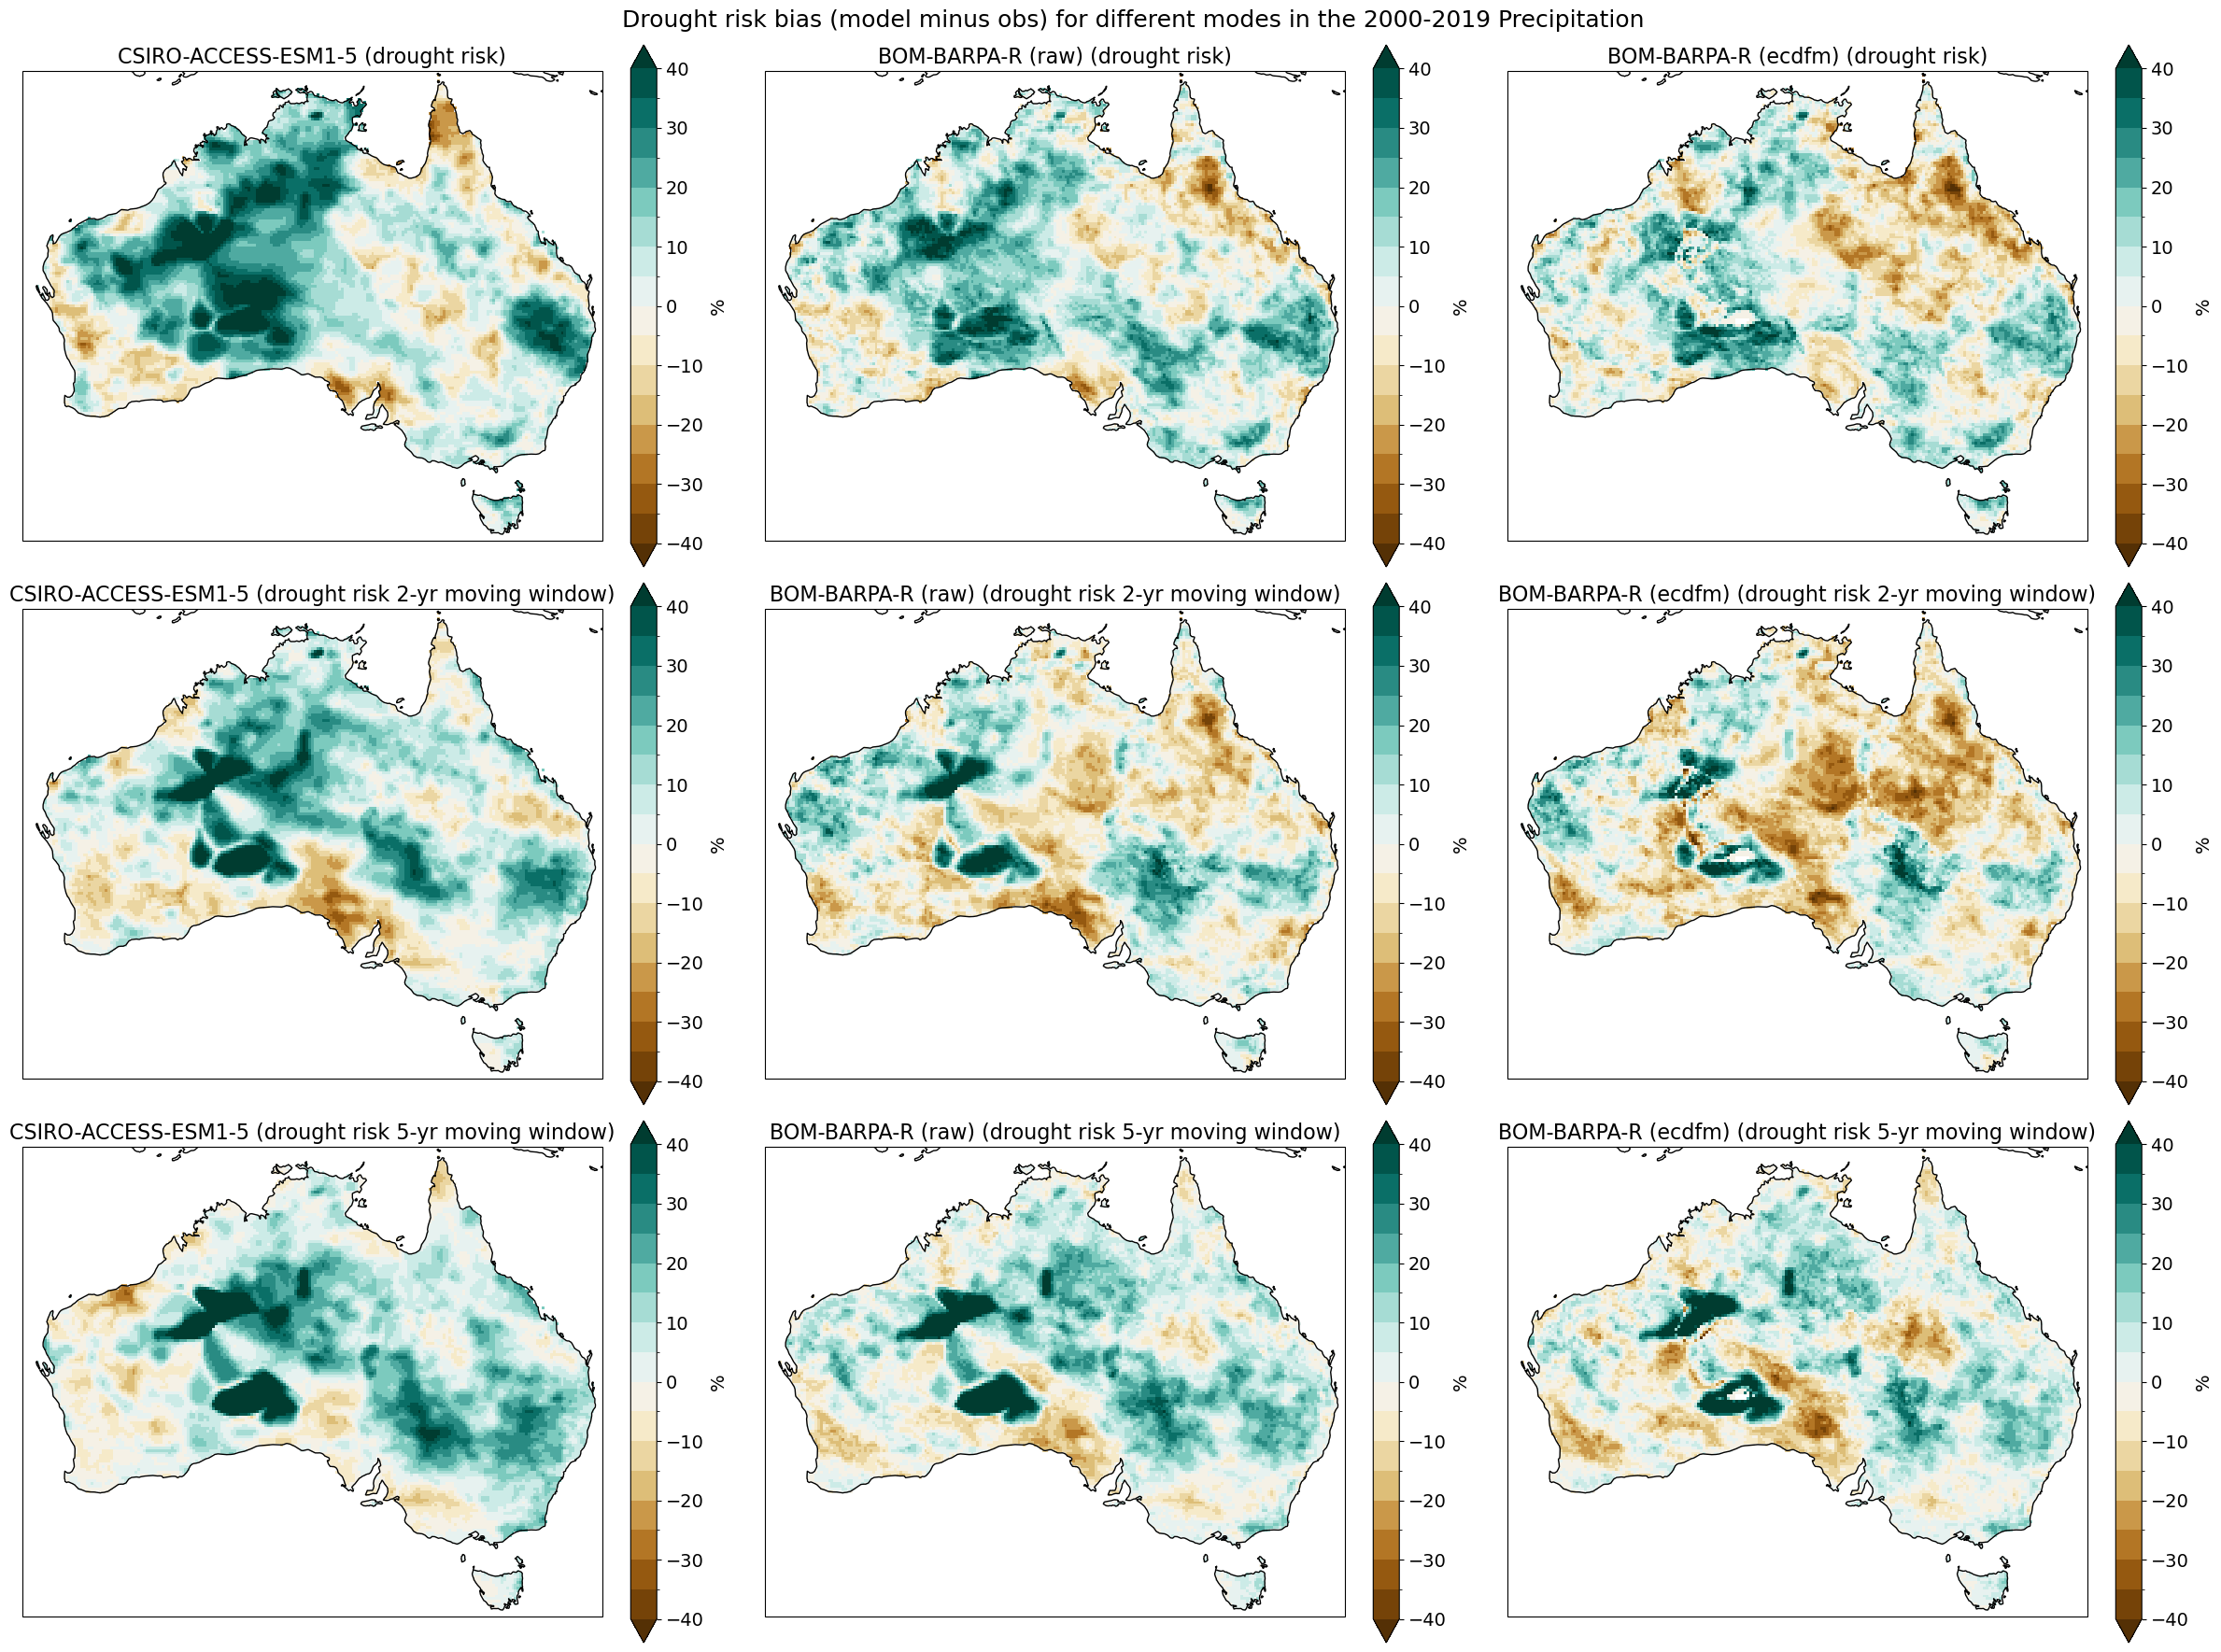

In [6]:
plot_comparison('pr', 'BOM-BARPA-R', 'BrBG', np.arange(-40, 40.1, 5))

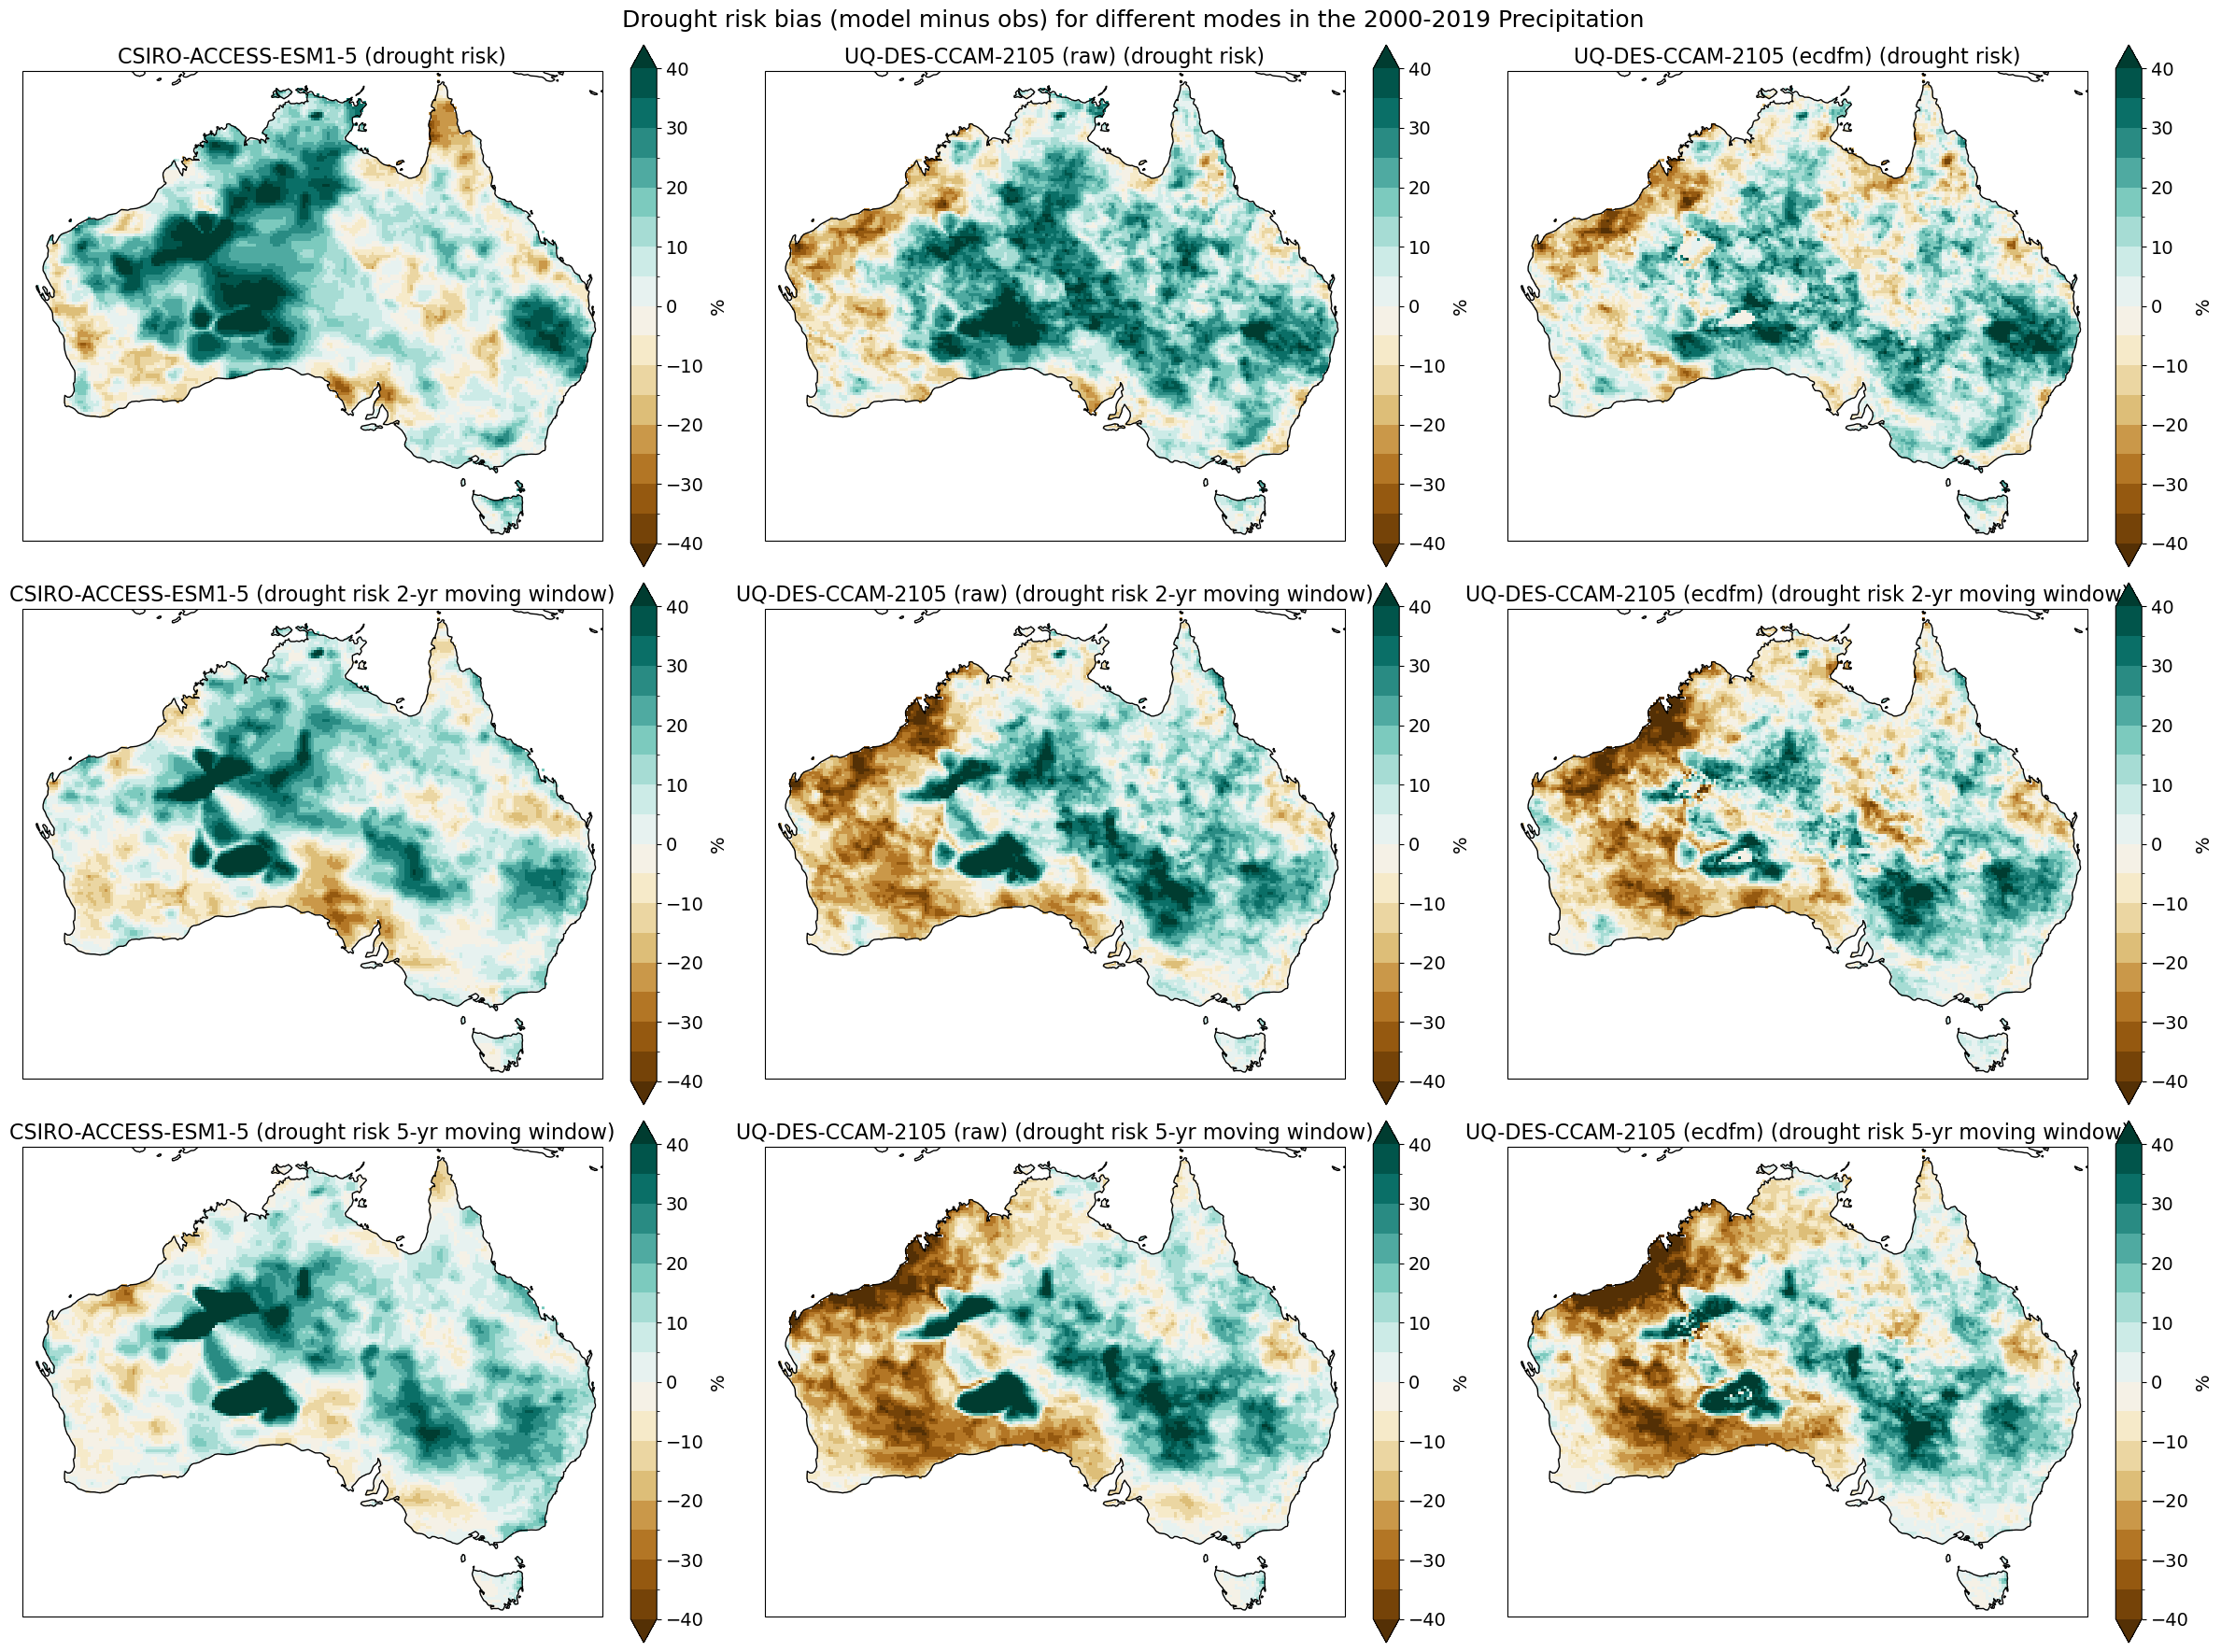

In [7]:
plot_comparison('pr', 'UQ-DES-CCAM-2105', 'BrBG', np.arange(-40, 40.1, 5))